In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

# Data
打开一张图片

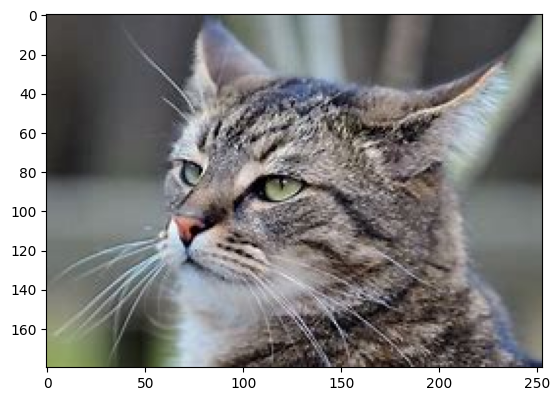

In [3]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)

In [4]:
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

# Patches Embeddings
将图片分成多个patches, 并将其铺平。铺平的方式两种：
1. 线性映射，也就是展开
2. 使用16*16卷积核，ViT使用的就是本方法

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int = 3, path_size:int = 16, emb_size:int = 768, img_size:int = 224):
        super(PatchEmbedding, self).__init__()
        self.path_size = path_size
        self.proj = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=path_size, stride=path_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // path_size)**2 + 1, emb_size))
    
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b)
        print('cls_token.shape: ', cls_token.shape)
        print('befor concat, x.shape: ', x.shape)
        x = torch.cat([cls_token, x], dim=1)
        print('positions.shape', self.positions.shape)
        x += self.positions
        return x

PatchEmbedding()(x).shape

cls_token.shape:  torch.Size([1, 1, 768])
befor concat, x.shape:  torch.Size([1, 196, 768])
positions.shape torch.Size([197, 768])


torch.Size([1, 197, 768])

# Transformer
ViT只是用到了Transformer中的Encoder模块。

## 多头注意模块

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        print("1qkv's shape: ", self.qkv(x).shape)
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        print("2qkv's shape: ", qkv.shape)
        
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        print("queries's shape: ", queries.shape)
        print("keys's shape: ", keys.shape)
        print("values's shape: ", values.shape)
        
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        print("energy's shape: ", energy.shape)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        
        scaling = self.emb_size ** (1/2)
        print("scaling: ", scaling)
        att = F.softmax(energy, dim=-1) / scaling
        print("att1' shape: ", att.shape)
        att = self.att_drop(att)
        print("att2' shape: ", att.shape)
        
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        print("out1's shape: ", out.shape)
        out = rearrange(out, "b h n d -> b n (h d)")
        print("out2's shape: ", out.shape)
        out = self.projection(out)
        print("out3's shape: ", out.shape)
        return out
    
patches_embedded = PatchEmbedding()(x)
print("patches_embedding's shape: ", patches_embedded.shape)
MultiHeadAttention()(patches_embedded).shape

cls_token.shape:  torch.Size([1, 1, 768])
befor concat, x.shape:  torch.Size([1, 196, 768])
positions.shape torch.Size([197, 768])
patches_embedding's shape:  torch.Size([1, 197, 768])
1qkv's shape:  torch.Size([1, 197, 2304])
2qkv's shape:  torch.Size([3, 1, 8, 197, 96])
queries's shape:  torch.Size([1, 8, 197, 96])
keys's shape:  torch.Size([1, 8, 197, 96])
values's shape:  torch.Size([1, 8, 197, 96])
energy's shape:  torch.Size([1, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([1, 8, 197, 197])
att2' shape:  torch.Size([1, 8, 197, 197])
out1's shape:  torch.Size([1, 8, 197, 96])
out2's shape:  torch.Size([1, 197, 768])
out3's shape:  torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

## Residuals模块

In [17]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [14]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [15]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [18]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

cls_token.shape:  torch.Size([1, 1, 768])
befor concat, x.shape:  torch.Size([1, 196, 768])
positions.shape torch.Size([197, 768])
1qkv's shape:  torch.Size([1, 197, 2304])
2qkv's shape:  torch.Size([3, 1, 8, 197, 96])
queries's shape:  torch.Size([1, 8, 197, 96])
keys's shape:  torch.Size([1, 8, 197, 96])
values's shape:  torch.Size([1, 8, 197, 96])
energy's shape:  torch.Size([1, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([1, 8, 197, 197])
att2' shape:  torch.Size([1, 8, 197, 197])
out1's shape:  torch.Size([1, 8, 197, 96])
out2's shape:  torch.Size([1, 197, 768])
out3's shape:  torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

In [19]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [20]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [21]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [22]:
summary(ViT(), (3, 224, 224), device='cpu')

cls_token.shape:  torch.Size([2, 1, 768])
befor concat, x.shape:  torch.Size([2, 196, 768])
positions.shape torch.Size([197, 768])
1qkv's shape:  torch.Size([2, 197, 2304])
2qkv's shape:  torch.Size([3, 2, 8, 197, 96])
queries's shape:  torch.Size([2, 8, 197, 96])
keys's shape:  torch.Size([2, 8, 197, 96])
values's shape:  torch.Size([2, 8, 197, 96])
energy's shape:  torch.Size([2, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([2, 8, 197, 197])
att2' shape:  torch.Size([2, 8, 197, 197])
out1's shape:  torch.Size([2, 8, 197, 96])
out2's shape:  torch.Size([2, 197, 768])
out3's shape:  torch.Size([2, 197, 768])
1qkv's shape:  torch.Size([2, 197, 2304])
2qkv's shape:  torch.Size([3, 2, 8, 197, 96])
queries's shape:  torch.Size([2, 8, 197, 96])
keys's shape:  torch.Size([2, 8, 197, 96])
values's shape:  torch.Size([2, 8, 197, 96])
energy's shape:  torch.Size([2, 8, 197, 197])
scaling:  27.712812921102035
att1' shape:  torch.Size([2, 8, 197, 197])
att2' shape:  torch.S